In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score

## Free GPU Cache

In [2]:
import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

# Step 0: Load Data

In [3]:
for dirname, _, filenames in os.walk('./titanic'):
    for filename in filenames:
        print(filename)

test.csv
train.csv


In [4]:
train = pd.read_csv("./titanic/train.csv")
test = pd.read_csv("./titanic/test.csv")

## Exploring the Data

PassengerId: Passenger ID

Survival: survival (存活), 0 = No, 1 = Yes

Pclass:   Ticket class (船票艙位), 1 = 1st(頭等), 2 = 2nd(商務), 3 = 3rd(經濟)

Sex:      Sex (性別), 0 = male, 1 = female

Age:      Age in years (年齡)

SibSp:    # of siblings / spouses aboard the Titanic (兄弟姊妹/配偶的數量)

Parch:    # of parents / children aboard the Titanic (父母/小孩的數量)

Ticket:   Ticket number (船票號碼)

Fare:     Passenger fare (船票價)

Cabin:    Cabin number (船艙號碼)

Embarked: Port of Embarkation (登船港口)


In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Shape of train & test

In [7]:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


## Drop the columns 'PassengerId', 'Name', 'Ticket', 'Cabin' because they do not play any significant role in the survival of a person

In [8]:
train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [9]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [10]:
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


## info(): show the imformation like non-null counts and data types for the columns

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


## describe(): show some stats about the numeric columns

In [12]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [13]:
train.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

# Step 1: Visualize the Data

## Column-wise Null values Heatmap

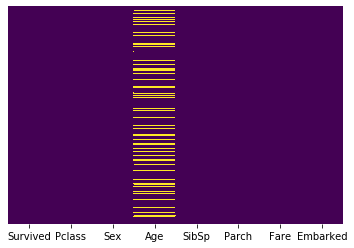

In [14]:
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

## Correlation heatmap

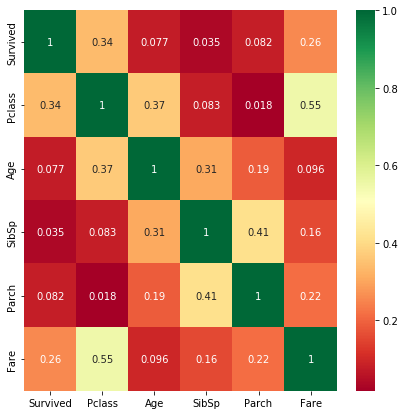

In [15]:
corr = train.corr()
corr = corr.apply(abs)
plt.figure(figsize=(7,7))
map = sns.heatmap(corr,annot=True,cmap="RdYlGn")

## Survived vs. Died Percentage

0    549
1    342
Name: Survived, dtype: int64

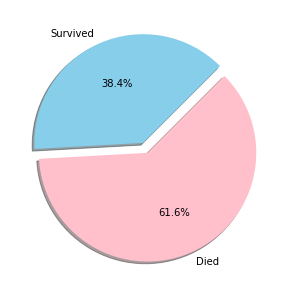

In [16]:
fig = plt.figure(figsize=(5,5))
colors = ["skyblue",'pink']
surv = train[train['Survived']==1]
died = train[train['Survived']==0]
ck = [surv['Survived'].count(),died['Survived'].count()]
piechart = plt.pie(ck,labels=["Survived","Died"],
autopct ='%1.1f%%',
shadow = True,
colors = colors,
startangle = 45,
explode=(0, 0.1))
train.Survived.value_counts()

## Distribution of the 'Age' column 

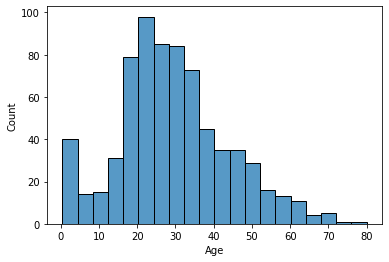

In [17]:
sns.histplot(train['Age'].dropna())

## Distribution of the 'Parch' column 

parch: Number of Parents/Children Aboard

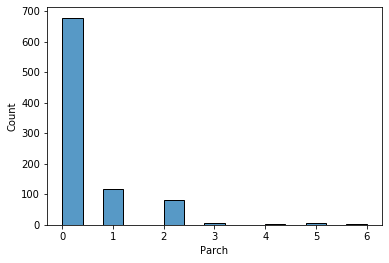

In [18]:
sns.histplot(train['Parch'].dropna(),bins=15)

## Distribution of the 'Pclass' column 

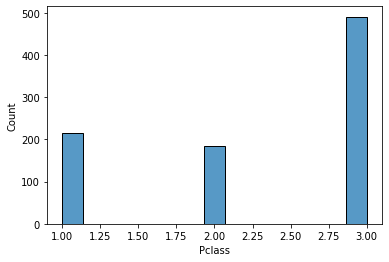

In [19]:
sns.histplot(train['Pclass'].dropna(),bins=15)

## Distribution of the 'Fare' column 

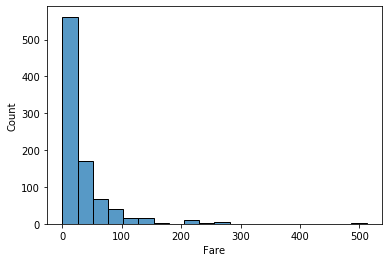

In [20]:
sns.histplot(train['Fare'].dropna(),bins=20)

## Distribution of the 'Sex' column 

/home/bakerchen/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


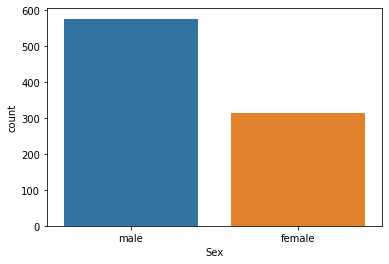

In [21]:
sns.countplot(train['Sex'].dropna())

In [1]:
# sns.countplot(train['Sex'], hue=train['Survived'])
# display(train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().round(3))

# Step 2: Feature Engineering

## Replace the null values in the 'Age' column with the column mean

In [23]:
# Replacing null values by column mean
train['Age'].fillna(train['Age'].mean(),inplace=True)

test['Age'].fillna(test['Age'].mean(),inplace=True)

## Replace the 0's and nulls in the 'Fare' column with the column mean

In [24]:
# Replacing 0’s & nulls by column mean
train['Fare'] = train['Fare'].replace(0, train['Fare'].mean())
train['Fare'].replace('nan',np.nan,inplace=True)
train['Fare'].fillna(train['Fare'].mean(),inplace=True)

test['Fare'] = test['Fare'].replace(0, test['Fare'].mean())
test['Fare'].replace('nan',np.nan,inplace=True)
test['Fare'].fillna(test['Fare'].mean(),inplace=True)

## Replace the null values in the 'Embarked' column with the column mean

In [25]:
# Replacing nulls by column mean 
train['Embarked'].replace('nan',np.nan,inplace=True)
train['Embarked'].fillna(train['Embarked'].mode()[0],inplace=True)

test['Embarked'].replace('nan',np.nan,inplace=True)
test['Embarked'].fillna(test['Embarked'].mode()[0],inplace=True)

## Print the unique values in the 'Sex' column

In [26]:
# Prining unique values in 'Sex' column
train['Sex'].unique()

array(['male', 'female'], dtype=object)

## Map the categorical values in the 'Sex' column to numeric values (0&1)

In [27]:
## Mapping categorical to numeric
train['Sex'] = train['Sex'].map({'male':0,'female':1})

test['Sex'] = test['Sex'].map({'male':0,'female':1})

## Print the unique values in the 'Embarked' columns

In [28]:
# Printing unique values in 'Embarked' column
train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

## Map the categorical values in this column to numeric values (0,1,2)

In [29]:
# Mappping categorical to numeric
train['Embarked'] = train['Embarked'].map({'S':0,'C':1,'Q':2})
test['Embarked'] = test['Embarked'].map({'S':0,'C':1,'Q':2})

## Take the log of the 'Age' column to handle skewness

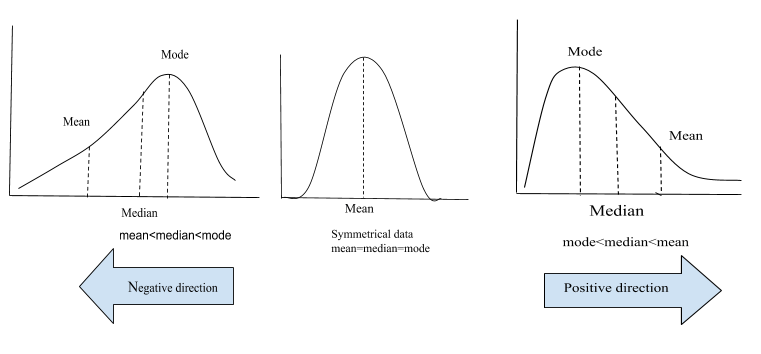

In [30]:
# https://stackoverflow.com/questions/51417483/mean-median-mode-lines-showing-only-in-last-graph-in-seaborn

### before

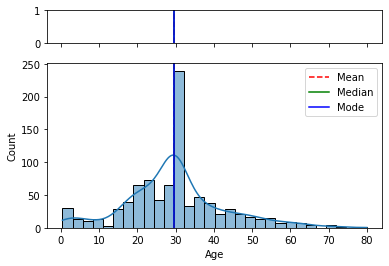

In [31]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})

data = train

data['Age'].dropna()

mean = data['Age'].mean()
median = data['Age'].median()
mode = data['Age'].mode().values[0]

# sns.boxplot(data=data, x='Age', ax=ax_box)
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')
ax_box.axvline(mode, color='b', linestyle='-')


sns.histplot(data=data, x='Age', ax=ax_hist, kde=True)
ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")
ax_hist.axvline(median, color='g', linestyle='-', label="Median")
ax_hist.axvline(mode, color='b', linestyle='-', label="Mode")


ax_hist.legend()

ax_box.set(xlabel='')
plt.show()

### after

In [32]:
# Handling skewness in 'Age' column
train['Age'] = np.log(train['Age'])

test['Age'] = np.log(test['Age'])

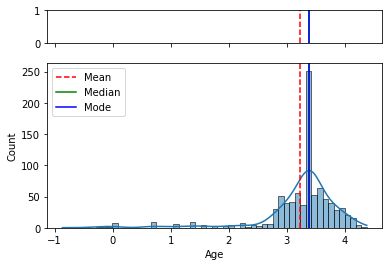

In [33]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})

data = train

data['Age'].dropna()

mean = data['Age'].mean()
median = data['Age'].median()
mode = data['Age'].mode().values[0]

# sns.boxplot(data=data, x='Age', ax=ax_box)
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')
ax_box.axvline(mode, color='b', linestyle='-')


sns.histplot(data=data, x='Age', ax=ax_hist, kde=True)
ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")
ax_hist.axvline(median, color='g', linestyle='-', label="Median")
ax_hist.axvline(mode, color='b', linestyle='-', label="Mode")


ax_hist.legend()

ax_box.set(xlabel='')
plt.show()

In [34]:
# https://stackoverflow.com/questions/51417483/mean-median-mode-lines-showing-only-in-last-graph-in-seaborn

## Take the log of the 'Fare' column to handle skewness

In [35]:
#Handling skewness in 'Fare' column
train['Fare']=np.log(train['Fare'])

test['Fare']=np.log(test['Fare'])

## Drop the 'Survived' column from train and assign it to y
## (this column is the target column)

In [36]:
x=train.drop(['Survived'],axis=1)

y=train['Survived']

## Split the train data into train & validation

### Prepare training & validation data

In [37]:
x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=0.2,random_state=0)

### training data

In [38]:
x_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
140,3,1,3.391117,0,2,2.724304,1
439,2,0,3.433987,0,0,2.351375,0
817,2,0,3.433987,1,1,3.611031,1
378,3,0,2.995732,0,0,1.389414,1
491,3,0,3.044522,0,0,1.981001,0
...,...,...,...,...,...,...,...
835,1,1,3.663562,1,1,4.420746,1
192,3,1,2.944439,1,0,2.061048,0
629,3,0,3.391117,0,0,2.045536,2
559,3,1,3.583519,1,0,2.856470,0


In [39]:
y_train

140    0
439    0
817    0
378    0
491    0
      ..
835    1
192    1
629    0
559    1
684    0
Name: Survived, Length: 712, dtype: int64

### validation data

In [40]:
x_val

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
495,3,0,3.391117,0,0,2.671269,1
648,3,0,3.391117,0,0,2.021548,0
278,3,0,1.945910,4,1,3.371597,2
31,1,1,3.391117,1,0,4.987167,1
255,3,1,3.367296,0,2,2.724304,1
...,...,...,...,...,...,...,...
780,3,1,2.564949,0,0,1.978128,1
837,3,0,3.391117,0,0,2.085672,0
215,1,1,3.433987,1,0,4.729818,1
833,3,0,3.135494,0,0,2.061048,0


In [41]:
y_val

495    0
648    0
278    0
31     1
255    1
      ..
780    1
837    0
215    1
833    0
372    0
Name: Survived, Length: 179, dtype: int64

### test data

In [42]:
x_test = test

In [43]:
x_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,3.540959,0,0,2.057860,2
1,3,1,3.850148,1,0,1.945910,0
2,2,0,4.127134,0,0,2.270836,2
3,3,0,3.295837,0,0,2.159003,0
4,3,1,3.091042,1,1,2.508582,0
...,...,...,...,...,...,...,...
413,3,0,3.410243,0,0,2.085672,0
414,1,1,3.663562,0,0,4.690430,1
415,3,0,3.650658,0,0,1.981001,0
416,3,0,3.410243,0,0,2.085672,0


# Step3: Create the Model

## Use XGBoost for the classification

In [45]:
# Specifying our classifier
xgbm = xgb.XGBClassifier(min_child_weight=1,
                         tree_method='gpu_hist',
                         sampling_method='uniform',
                         eval_metric='error')

## Define Hyperparameters

In [46]:
n_estimators = [100, 200, 300, 400]
max_depth = [5, 10, 15]
learning_rate = [0.01, 0.06, 0.1]
colsample_bytree = [0.2, 0.5, 0.8]

## Create Feature Map

In [47]:
from graphviz import Digraph
from xgboost import plot_tree

In [48]:
def create_feature_map(features):
    outfile = open("xgb.fmap", "w")
    i = 0
    for feat in features:
        outfile.write("{0}\t{1}\tq\t".format(i, feat))
        i = i+1
    outfile.close

## Use GridSearchCV to find the best parameters for our model

In [54]:
search_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'learning_rate': learning_rate,
               'colsample_bytree': colsample_bytree}

In [55]:
search_grid

{'n_estimators': [100, 200, 300, 400],
 'max_depth': [5, 10, 15],
 'learning_rate': [0.01, 0.06, 0.1],
 'colsample_bytree': [0.2, 0.5, 0.8]}

In [56]:
# Searching for the best parameters
xgbm_search = GridSearchCV(estimator=xgbm,
                           param_grid=search_grid,
                           cv=5,
                           n_jobs=-1,
                           verbose=2,
                           return_train_score=True)

In [57]:
# free_gpu_cache()
xgbm_search.fit(x_train, y_train)

# eval_set = [(x_train, y_train),(x_val, y_val)]
# xgbm_search.fit(x_train, y_train, eval_metric=['error','logloss','auc'], eval_set=eval_set, verbose=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 301 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  4.6min finished
/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, eval_metric='error',
                                     gamma=None, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=1,
                                     missing=nan,...
                                     scale_pos_weight=None, subsample=None,
                                     tree_method='gpu_hist',
                                     use_label_encoder=True,
                                     validate_parameters=None, verbosity=None),
      

In [58]:
xgbm_search.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.01,
 'max_depth': 5,
 'n_estimators': 400}

In [59]:
xgbm_search_best = xgb.XGBClassifier(n_estimators=400,
                                     min_child_weight=1,
                                     tree_method='gpu_hist',
                                     max_depth=5,
                                     learning_rate=0.01,
                                     sampling_method="uniform",
                                     eval_metric="error",
                                     colsample_bytree=0.8)

In [60]:
xgbm_search_best.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='error',
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=32,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, sampling_method='uniform',
              scale_pos_weight=1, subsample=1, tree_method='gpu_hist',
              use_label_encoder=True, validate_parameters=1, verbosity=None)

## Calculating the model's score

In [61]:
# Calculating the model's score
xgbm_search_best.score(x_train,y_train)

0.8778089887640449

In [62]:
y_pred = xgbm_search_best.predict(x_val)
accuracy_score(y_val, y_pred)

0.8491620111731844

## Cross Validation Scores

In [63]:
cross_score = cross_val_score(xgbm_search_best, x_val, y_val, cv=10)
print("Cross validation scores: {}".format(cross_score))

/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Cross validation scores: [0.83333333 0.83333333 0.77777778 0.61111111 0.77777778 0.83333333
 0.83333333 0.88888889 0.83333333 0.88235294]


In [64]:
average_cross_score = sum(cross_score)/len(cross_score)
print("Average cross validation scores: {}".format(average_cross_score))

Average cross validation scores: 0.8104575163398693


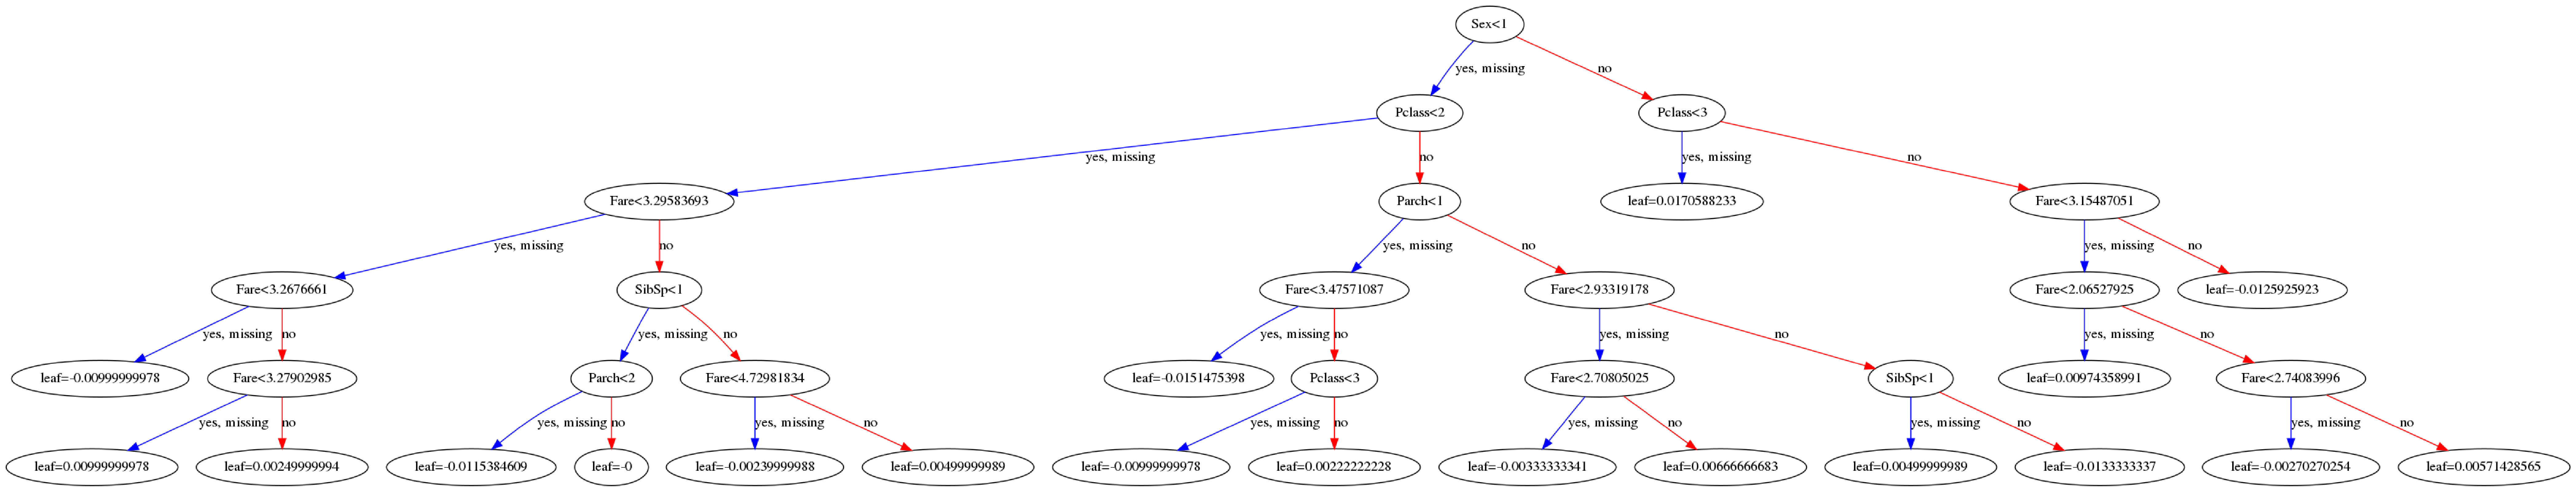

In [65]:
create_feature_map(x_train.columns)
plot_tree(xgbm_search_best, 
          num_trees=0, 
          fmap="xgb.fmap") 

fig = plt.gcf()
fig.set_size_inches(150, 100)

plt.savefig("xgbm_search_best.png")
plt.show()

## Use RandomizedSearchCV to find the best parameters for our model

In [66]:
n_estimators = [300, 400]
max_depth = [5, 10]
learning_rate = [0.01, 0.1]
colsample_bytree = [0.2, 0.8]

In [67]:
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'learning_rate': learning_rate,
               'colsample_bytree': colsample_bytree}

In [68]:
random_grid

{'n_estimators': [300, 400],
 'max_depth': [5, 10],
 'learning_rate': [0.01, 0.1],
 'colsample_bytree': [0.2, 0.8]}

In [69]:
xgbm_random = RandomizedSearchCV(estimator=xgbm,
                                 param_distributions=random_grid,
                                 n_iter=100,
                                 cv=5, # cross validation
                                 verbose=2,
                                 random_state=np.random.randint(256),
                                 n_jobs=-1)

In [70]:
# free_gpu_cache()
xgbm_random.fit(x_train, y_train)

# eval_set = [(x_train, y_train),(x_val, y_val)]
# xgbm_random.fit(x_train, y_train, eval_metric=['error','logloss','auc'], eval_set=eval_set, verbose=True)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 16 is smaller than n_iter=100. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 out of  80 | elapsed:  1.0min remaining:   23.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.1min finished
/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           eval_metric='error', gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=1, missin...
                                           subsample=None,
                                           tree_method='gpu_hist',
                                           use_label_encoder=True,
                               

In [71]:
xgbm_random.best_params_

{'n_estimators': 400,
 'max_depth': 5,
 'learning_rate': 0.01,
 'colsample_bytree': 0.8}

In [72]:
xgbm_random_best = xgb.XGBClassifier(n_estimators=300,
                                     min_child_weight=1,
                                     tree_method='gpu_hist',
                                     max_depth=5,
                                     learning_rate=0.01,
                                     sampling_method="uniform",
                                     eval_metric="error",
                                     colsample_bytree=0.8)

In [73]:
xgbm_random_best.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='error',
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=32,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, sampling_method='uniform',
              scale_pos_weight=1, subsample=1, tree_method='gpu_hist',
              use_label_encoder=True, validate_parameters=1, verbosity=None)

## Calculating the model's score

In [74]:
# Calculating the model's score
xgbm_random_best.score(x_train,y_train)

0.875

In [75]:
y_pred = xgbm_random_best.predict(x_val)
accuracy_score(y_val, y_pred)

0.8379888268156425

## Cross Validation Scores

In [76]:
cross_score = cross_val_score(xgbm_random_best, x_val, y_val, cv=10)
print("Cross validation scores: {}".format(cross_score))

/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Cross validation scores: [0.83333333 0.83333333 0.77777778 0.61111111 0.77777778 0.83333333
 0.83333333 0.88888889 0.77777778 0.88235294]


In [77]:
average_cross_score = sum(cross_score)/len(cross_score)
print("Average cross validation scores: {}".format(average_cross_score))

Average cross validation scores: 0.8049019607843138


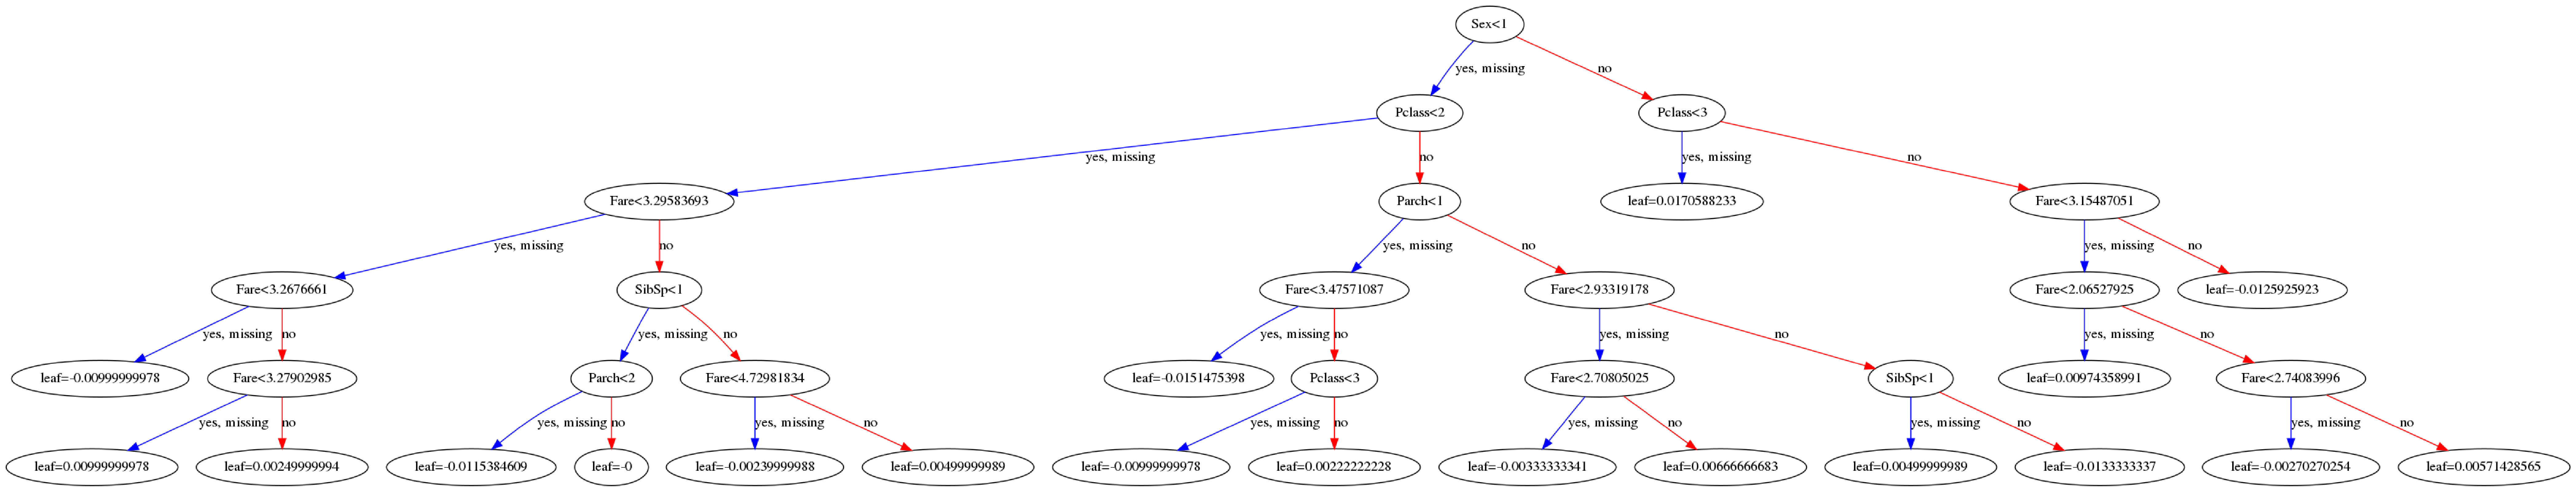

In [78]:
create_feature_map(x_train.columns)
plot_tree(xgbm_search_best, 
          num_trees=0, 
          fmap="xgb.fmap") 

fig = plt.gcf()
fig.set_size_inches(150, 100)

plt.savefig("xgbm_random_best.png")
plt.show()